# Spatial Distributions of SIC and PSL

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import xarray as xr
import cftime
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
import netCDF4, h5netcdf, dask
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib import cm, colors, colormaps
from scipy.io import loadmat

# custom package
from icepy.analysis import *
from icepy.plot import *

monthletters = ['J','F','M','A','M','J','J','A','S','O','N','D']

# Open Datasets

In [2]:
sic_path = "../data/obs/Had2CIS/sic_1x1/had2cis_1x1_198001_202004_sicn.nc"
psl_path = "../data/obs/ERA5/psl_1x1/psl_Amon_ERA5obs_CanESM5grid_197901-201912_1x1.nc"

# open data
sic_Had2CIS = format_time_coord(xr.open_dataset(sic_path),'1980-01','2020-04',freq='M')
psl_ERA5 = format_time_coord(xr.open_dataset(psl_path),'1979-01','2019-12',freq='M')

# calculate anomalies
method = 'mean'
daterange = (1889,3019)
sic_anom_Had2CIS = remove_trend(sic_Had2CIS,'SICN',method=method,ref_period=daterange)
psl_anom_ERA5 = remove_trend(psl_ERA5,'psl',method=method,ref_period=daterange)

c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dataset['time'] = date_range
c:\Users\Robert payne\Desktop\University\sea_ice\python\icepy\analysis.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable c

# Plots

In [3]:
def _add_gridlines (ax,lons=[-90,0,90,180]):
    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=False,
                  linewidth=.5, color='black', alpha=1, linestyle='--',dms=True)
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xlines = True
    gl.ylines = False
    gl.xlocator = mticker.FixedLocator(lons)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'grey'}
    gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

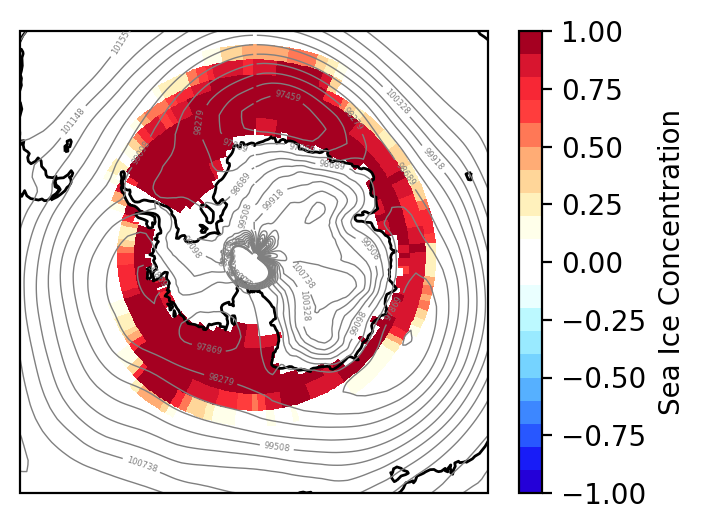

In [4]:
cmap = colors.ListedColormap(loadmat('./cmaps/cmap_jet3.mat')['cmap'], name='jet3')
cmap.set_bad(color='grey', alpha=1.0)  # Specify the color for NaN values
    
# circular boundary around the plot
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], .5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# plot parameters/design
projection = ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)
transform = ccrs.PlateCarree()                                              
domain = [-180,180,-90,-47.5]
psllevels = np.linspace(95000, 120000, 62)

# data to plot
sic = sic_Had2CIS.where((sic_anom_Had2CIS['time.year']==2016) & (sic_anom_Had2CIS['time.month']==10),drop=True)
psl = psl_ERA5.where((psl_ERA5['time.year']==2016) & (psl_ERA5['time.month']==10),drop=True)
sic['SICN'] = sic['SICN'][list(sic.dims).index('time')]
psl['psl'] = psl['psl'][list(psl.dims).index('time')]

# plot
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(4,3),facecolor='white',dpi=200,subplot_kw={'projection':projection})
ax.set_extent(domain,transform)
#ax.set_boundary(circle, transform=ax.transAxes)
#_add_gridlines(ax,[20,90,160,-130,-60])
sicplot = sic['SICN'].plot(ax=ax,transform=transform,cmap=cmap,vmin=-1,vmax=1,cbar_kwargs={"label":"Sea Ice Concentration"})
pslplot = psl['psl'].plot.contour(ax=ax,transform=transform,colors='grey',levels=psllevels,linewidths=.5)
plt.clabel(pslplot, inline=True, fontsize=3)
ax.coastlines()

plt.show()


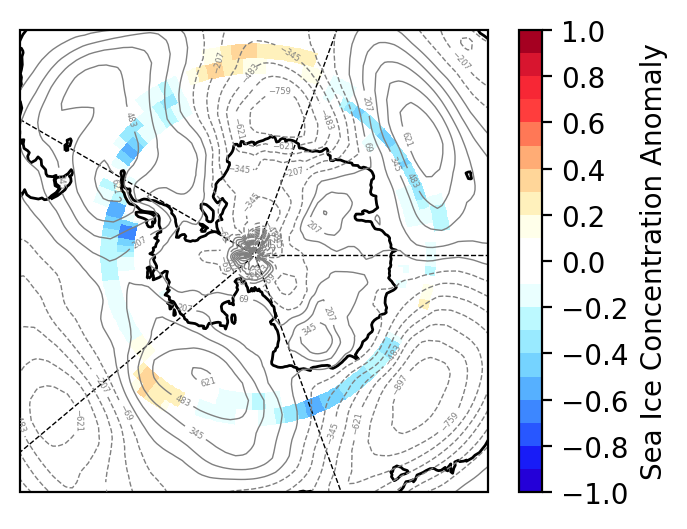

In [5]:
cmap = colors.ListedColormap(loadmat('./cmaps/cmap_jet3.mat')['cmap'], name='jet3')
cmap.set_bad(color='grey', alpha=1.0)  # Specify the color for NaN values
    
# circular boundary around the plot
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], .5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# plot parameters/design
projection = ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)
transform = ccrs.PlateCarree()                                              
domain = [-180,180,-90,-47.5]
psllevels = np.linspace(-2000,2000,30)

# data to plot
sic = sic_anom_Had2CIS.where((sic_anom_Had2CIS['time.year']==2016) & (sic_anom_Had2CIS['time.month']==10),drop=True)
psl = psl_anom_ERA5.where((psl_anom_ERA5['time.year']==2016) & (psl_anom_ERA5['time.month']==10),drop=True)
sic['SICN'] = sic['SICN'][list(sic.dims).index('time')]
psl['psl'] = psl['psl'][list(psl.dims).index('time')]

# plot
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(4,3),facecolor='white',dpi=200,subplot_kw={'projection':projection})
ax.set_extent(domain,transform)
#ax.set_boundary(circle, transform=ax.transAxes)
_add_gridlines(ax,[20,90,160,-130,-60])
sicplot = sic['SICN'].plot(ax=ax,transform=transform,cmap=cmap,vmin=-1,vmax=1,cbar_kwargs={"label":"Sea Ice Concentration Anomaly","ticks":np.arange(-1,1.2,.2)})
pslplot = psl['psl'].plot.contour(ax=ax,transform=transform,colors='grey',levels=psllevels,linewidths=.5)
plt.clabel(pslplot, inline=True, fontsize=3)
ax.coastlines()

plt.show()

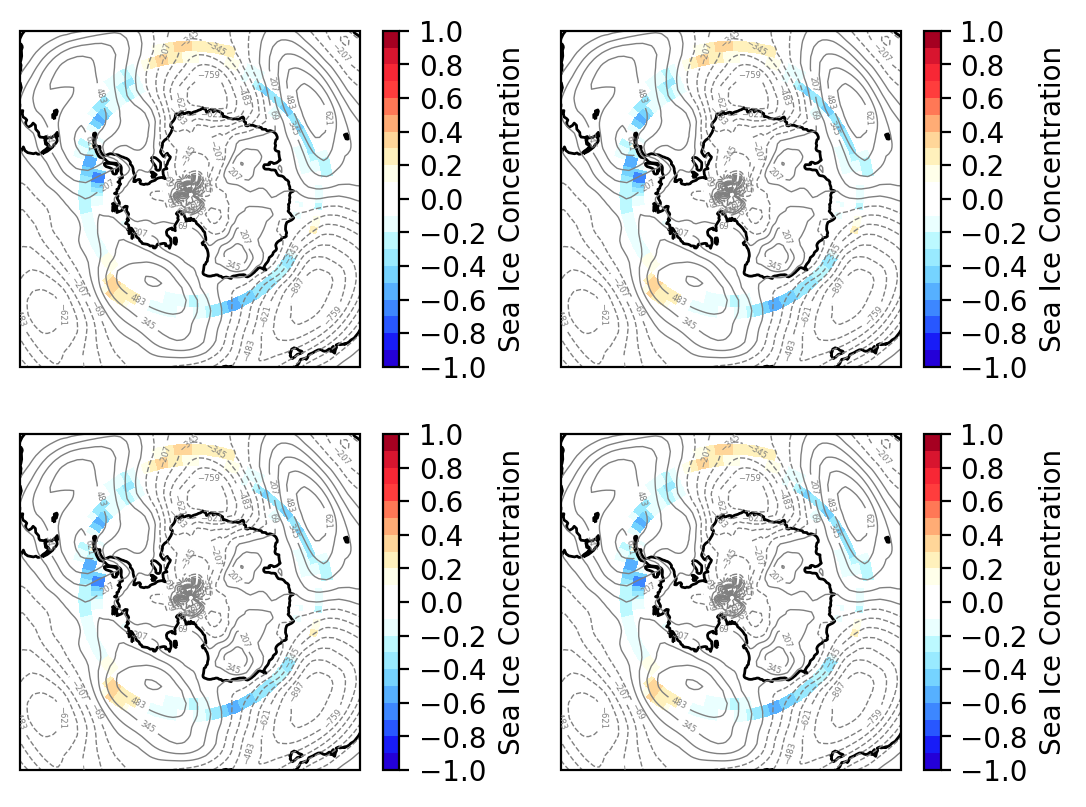

In [7]:
sicfields = [[sic,sic],[sic,sic]]
pslfields = [[psl,psl],[psl,psl]]

plot_fields([sicfields,pslfields],['SICN','psl'],clevels=psllevels)